# Final Project Code (Visualizations, Tables, Models)

In [40]:
# Loading in Data
df_AK = spark.read\
.format("csv")\
.option("header", "true")\
.option("nullValue", "NA")\
.option("delimiter", "\t")\
.option("inferSchema", "true")\
.load("gs://pstat135-11/VM2Uniform/VM2Uniform--AK--2021-02-03.tab")

In [41]:
# Importing Packages
import pandas as pd
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as fn
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as fn

## 3. Data Description

### 3.1 (Alaska's Demographic)

<AxesSubplot:title={'center':'Count of Ethnicities in Dataset'}, xlabel='Ethnicity', ylabel='# of Registered Voters'>

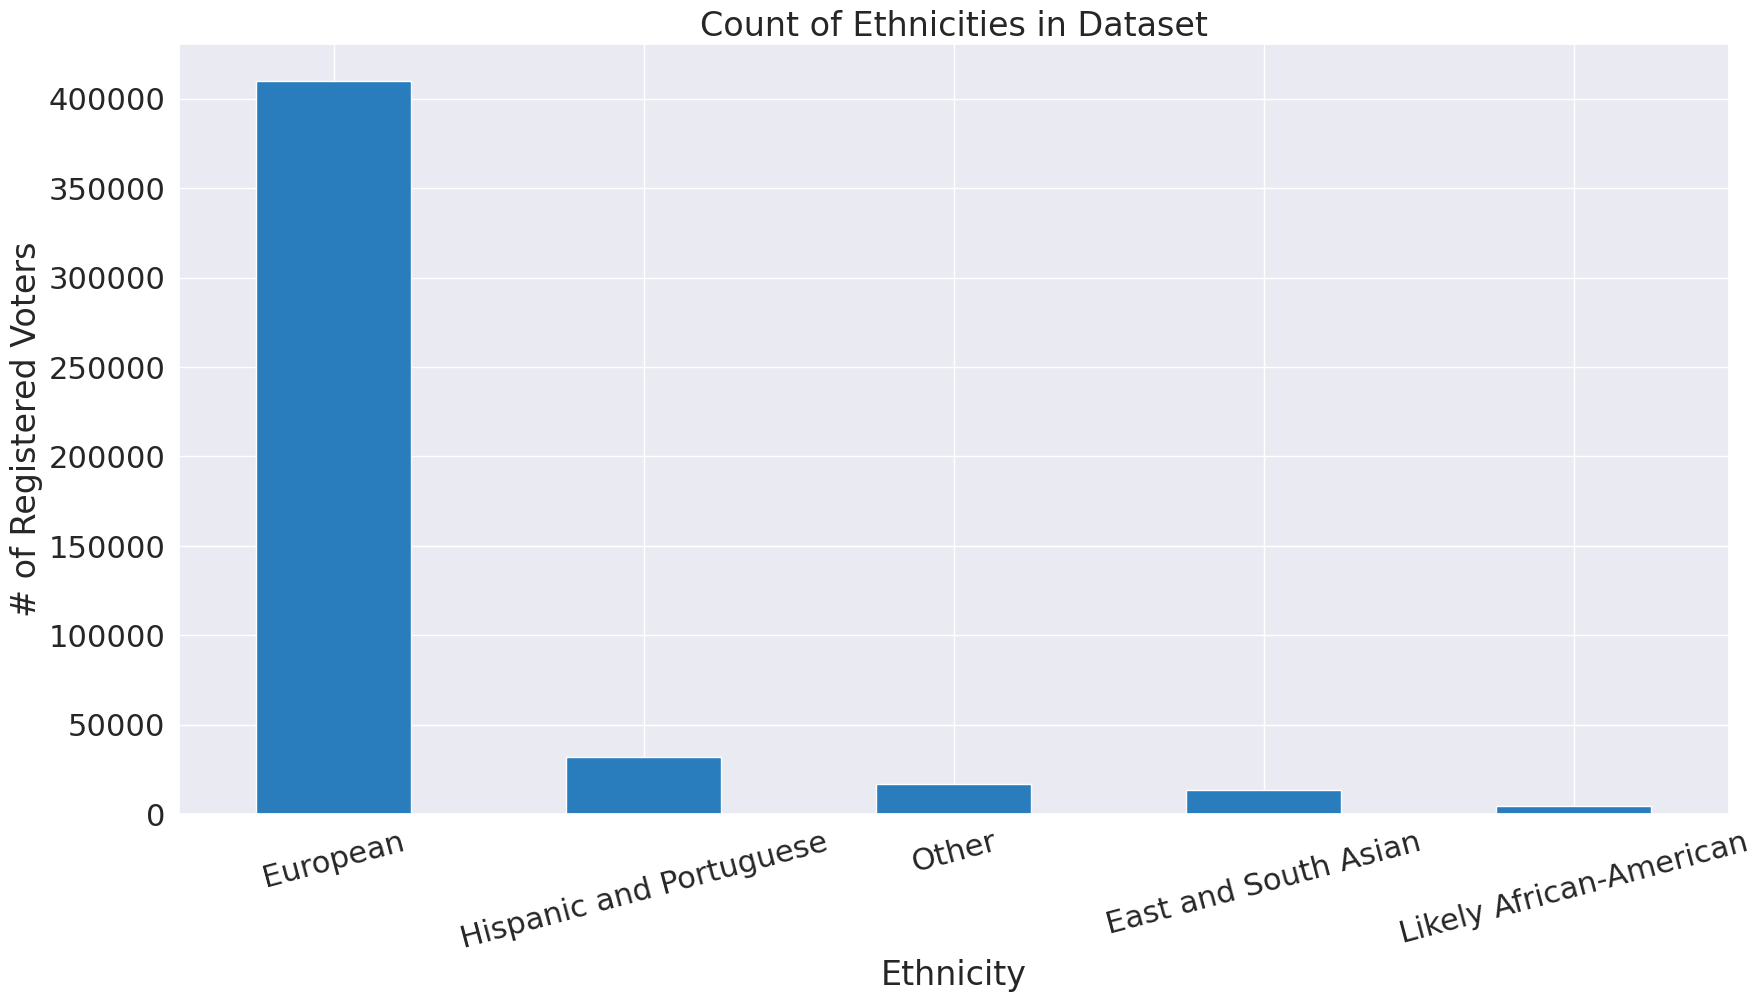

In [128]:
#FIGURE 4.1
# ethnic group counts

df_AK_ethnicgroup = df_AK.select(['EthnicGroups_EthnicGroup1Desc'])


df_AK_ethnicgroup = df_AK_ethnicgroup.groupBy('EthnicGroups_EthnicGroup1Desc')\
    .agg(count('EthnicGroups_EthnicGroup1Desc').alias('ethnicgroup_count')) \
    .orderBy(col('ethnicgroup_count').desc()).dropna()

df_AK_ethnicgroup_plt = df_AK_ethnicgroup.toPandas()
plt.rcParams.update({'font.size': 10})
df_AK_ethnicgroup_plt.plot.bar(x = 'EthnicGroups_EthnicGroup1Desc', y = 'ethnicgroup_count', 
                               xlabel = 'Ethnicity', ylabel = '# of Registered Voters', 
                               title = 'Count of Ethnicities in Dataset', rot = 15, legend = False, color = '#2A7DBD')

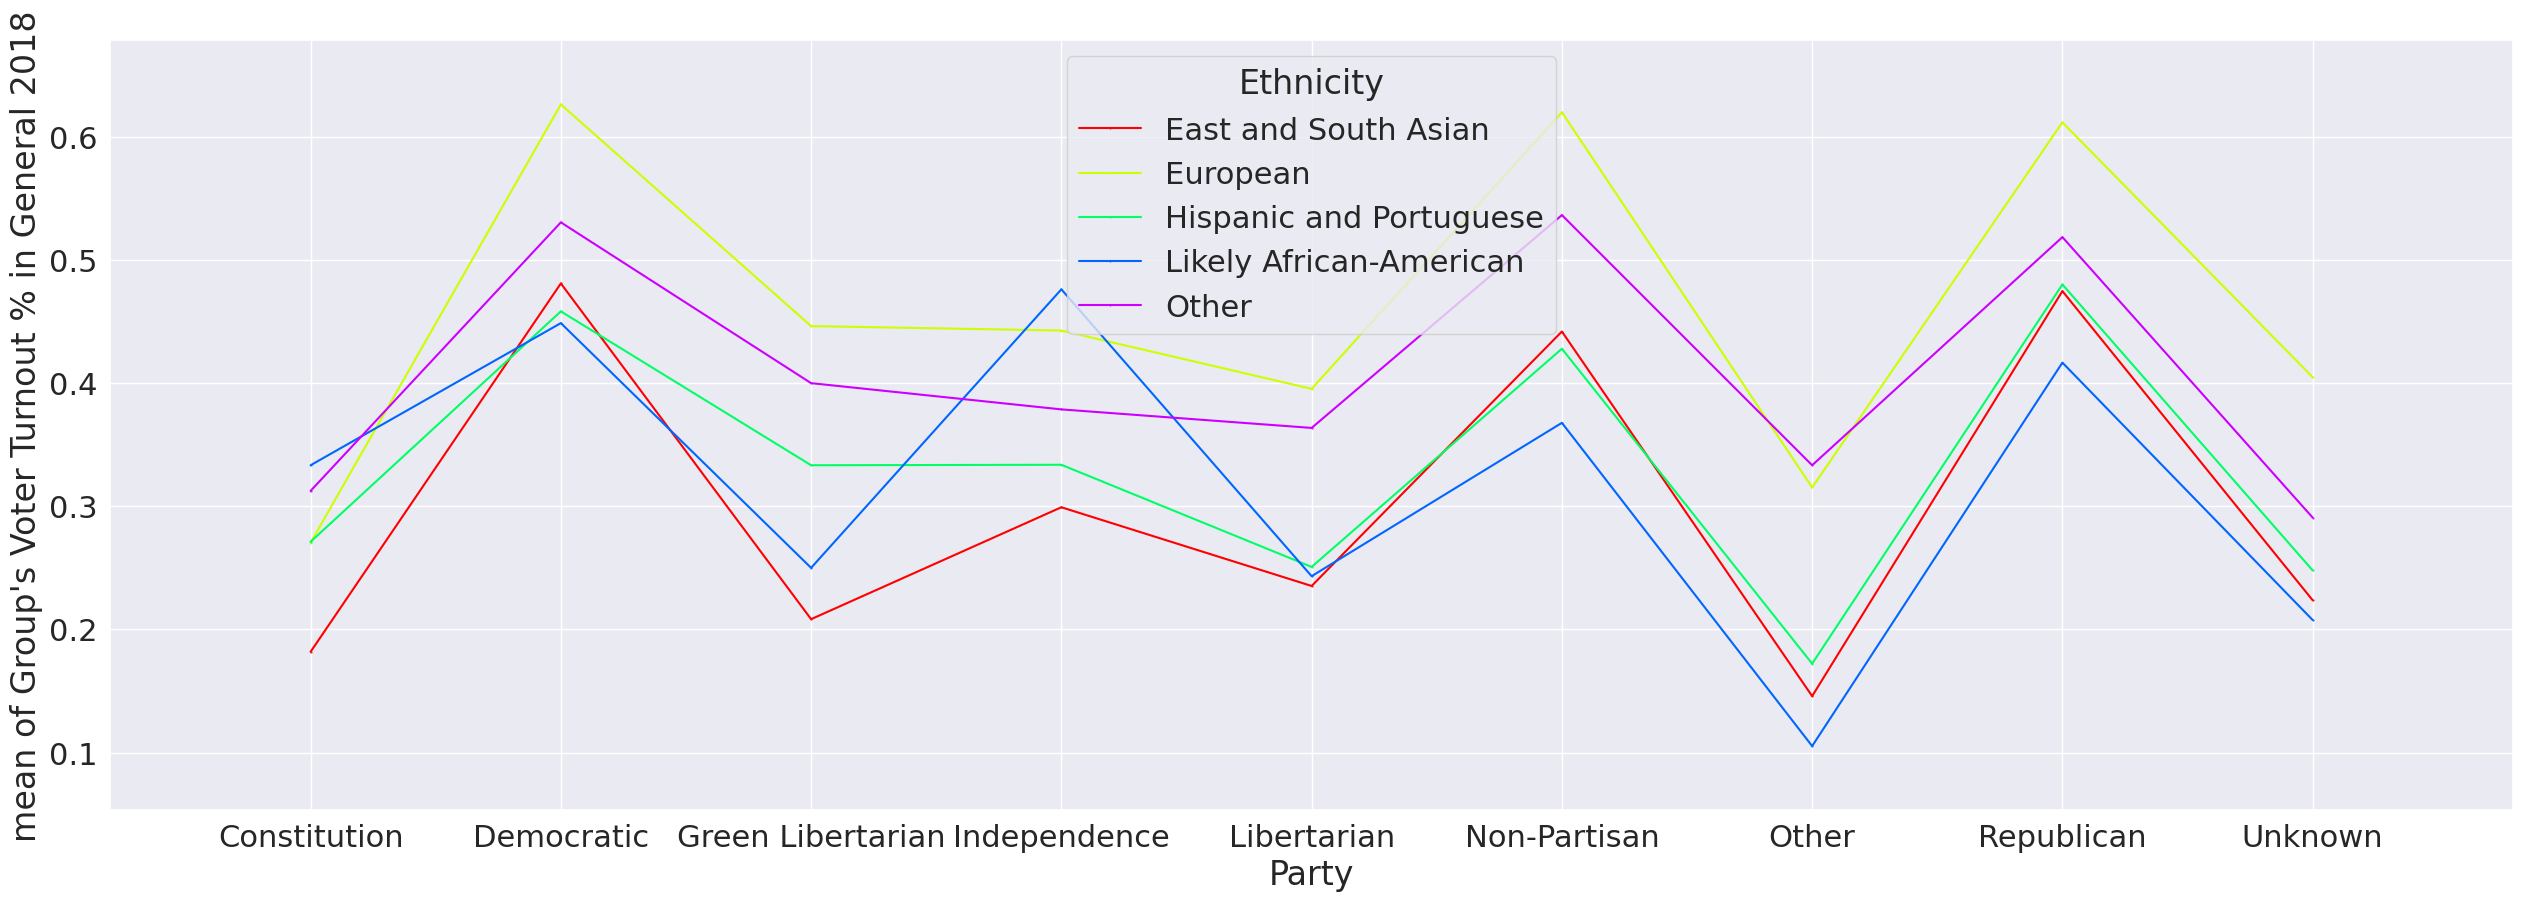

In [130]:
# FIGURE 4.2
# Plotting Interaction plot
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(31, 10))
fig = interaction_plot(
    x=eth_party_turnout_plt['Parties_Description'],
    trace=eth_party_turnout_plt['EthnicGroups_EthnicGroup1Desc'],
    response=eth_party_turnout_plt['General_2018'],
    ms=1,
    xlabel = "Party",
    ylabel = "Group's Voter Turnout % in General 2018",
    legendtitle = "Ethnicity",
    ax=ax)

In [14]:
df_selected = df_AK.select('Languages_Description',
                           'Ethnic_Description',
                          'EthnicGroups_EthnicGroup1Desc',
                           'CommercialData_EstimatedHHIncome',
                          'Voters_Age',
                           'Voters_Gender',
                          'Parties_Description',
                          'Residence_Addresses_City',
                           'MaritalStatus_Description',
                          'General_2018',
                          'CommercialData_EstimatedHHIncomeAmount')

df_selected = df_selected.na.fill(value='N',subset=['General_2018'])
df_selected = df_selected.withColumn('General_2018', translate('General_2018', 'Y', '1'))
df_selected = df_selected.withColumn('General_2018', translate('General_2018', 'N', '0'))
df_selected = df_selected.withColumn('General_2018', col('General_2018').cast('int'))

eth_party_turnout = df_selected.groupBy('Parties_Description','EthnicGroups_EthnicGroup1Desc')\
    .agg(avg('General_2018').alias('General_2018'))\
    .orderBy(col('General_2018').desc())
eth_party_turnout_plt = eth_party_turnout.toPandas()

<AxesSubplot:title={'center':'General 2018 Election Turnout by Ethnicity'}, xlabel='Ethnicity', ylabel='General 2018 Election Turnout'>

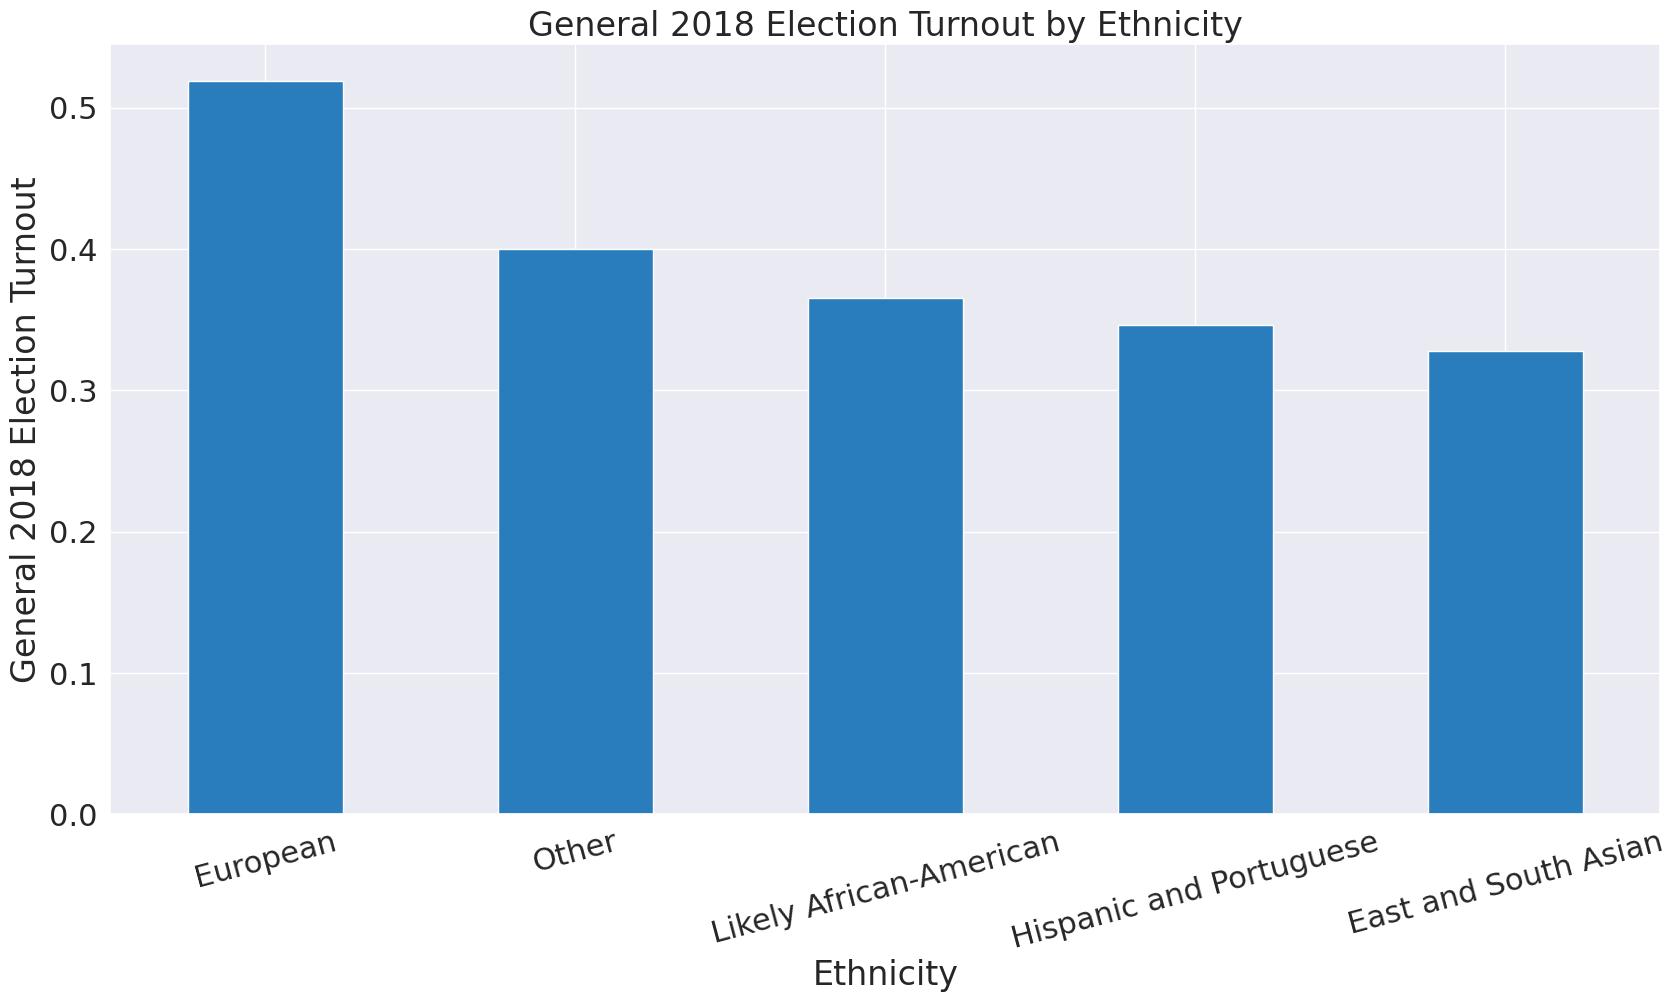

In [132]:
# Figure 4.3
# Ethnic Group Voter Turnout
df_AK_ethnicgroup = df_AK.select(['EthnicGroups_EthnicGroup1Desc', 'General_2018'])

df_AK_ethnicgroup = df_AK_ethnicgroup.na.fill(value='N',subset=['General_2018'])
df_AK_ethnicgroup = df_AK_ethnicgroup.withColumn('General_2018', translate('General_2018', 'Y', '1'))
df_AK_ethnicgroup = df_AK_ethnicgroup.withColumn('General_2018', translate('General_2018', 'N', '0'))
df_AK_ethnicgroup = df_AK_ethnicgroup.withColumn('General_2018', col('General_2018').cast('int'))

df_AK_ethnicgroup_turnout = df_AK_ethnicgroup.groupBy('EthnicGroups_EthnicGroup1Desc')\
    .agg(count('EthnicGroups_EthnicGroup1Desc').alias('ethnicgroup_count'),
         avg('General_2018').alias('general_2018_turnout'))\
    .orderBy(col('general_2018_turnout').desc()).drop('ethnicgroup_count').dropna()

df_AK_ethnicgroup_turnout = df_AK_ethnicgroup_turnout.toPandas()
plt.rcParams.update({'font.size': 10})
df_AK_ethnicgroup_turnout.plot.bar(x = 'EthnicGroups_EthnicGroup1Desc', y = 'general_2018_turnout', 
                               xlabel = 'Ethnicity', ylabel = 'General 2018 Election Turnout', 
                               title = 'General 2018 Election Turnout by Ethnicity', rot = 15, legend = False, color = '#2A7DBD')

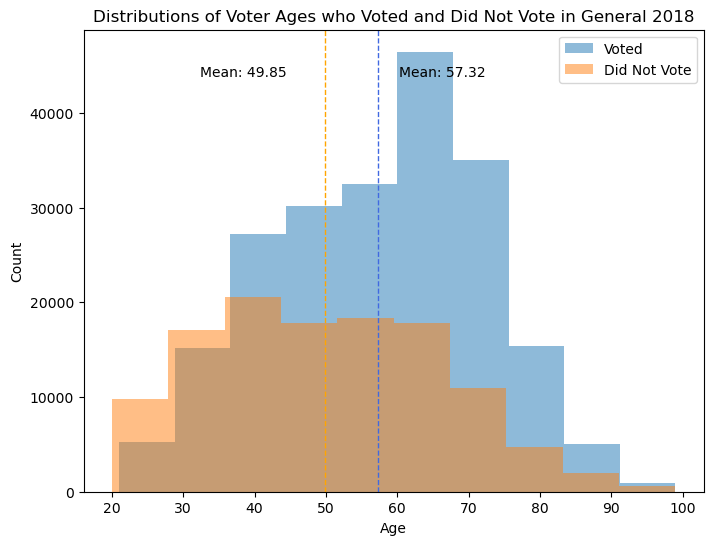

In [43]:
# Figure 4.4
# Age vs Voted/not Voted
df_AK_age = df_AK.select(['Voters_Age', 'General_2018'])
df_AK_age = df_AK_age.na.fill(value='N',subset=['General_2018'])
df_AK_age = df_AK_age.withColumn('Voters_Age', col('Voters_Age').cast('int'))

df_AK_age_Y = df_AK_age.filter(df_AK_age.General_2018 == 'Y').dropna()
df_AK_age_Y.select('Voters_Age').summary()
df_AK_age_Y = df_AK_age_Y.collect()
df_AK_age_N = df_AK_age.filter(df_AK_age.General_2018 == 'N').dropna()
df_AK_age_N.select('Voters_Age').summary()
df_AK_age_N = df_AK_age_N.collect()

df_AK_age_Y_list = [df_AK_age_Y[i][0] for i in range(len(df_AK_age_Y))]
df_AK_age_N_list = [df_AK_age_N[i][0] for i in range(len(df_AK_age_N))]

%matplotlib inline
from matplotlib import pyplot as plt
from statistics import mean
import seaborn
plt.rcParams.update({'font.size': 10})
plt.hist(df_AK_age_Y_list, bins=None, alpha=0.5, label='Voted')
plt.axvline(mean(df_AK_age_Y_list), color='royalblue', linestyle='dashed', linewidth=1)
plt.hist(df_AK_age_N_list, bins=None, alpha=0.5, label='Did Not Vote')
plt.axvline(mean(df_AK_age_N_list), color='orange', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(mean(df_AK_age_Y_list)*1.05, max_ylim*0.9, 'Mean: {:.2f}'.format(mean(df_AK_age_Y_list)))
plt.text(mean(df_AK_age_N_list)*0.65, max_ylim*0.9, 'Mean: {:.2f}'.format(mean(df_AK_age_N_list)))
plt.legend(loc='upper right')
plt.title('Distributions of Voter Ages who Voted and Did Not Vote in General 2018')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

### 3.2 (Alaska's Commercial Data)

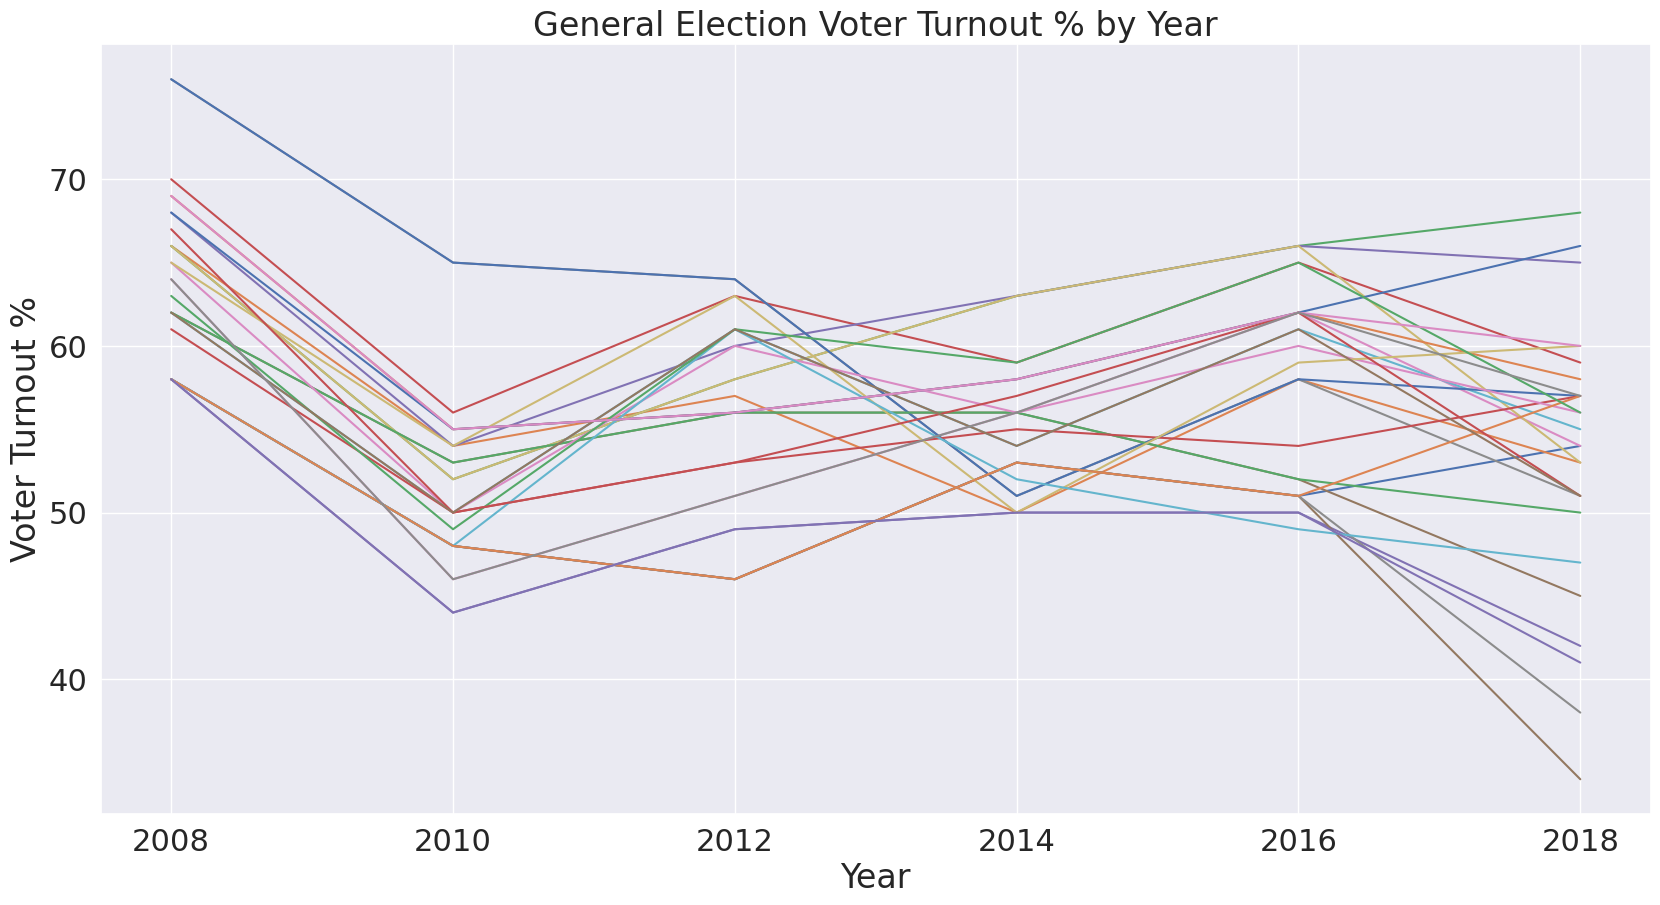

In [89]:
# Figure 4.5
# Plot of voter turnout by year by county

df_AK = df_AK.withColumn("G18_TurnoutAll",
   fn.regexp_replace(fn.col("ElectionReturns_G18CountyTurnoutAllRegisteredVoters"), "[%]", "").cast('int'))
df_AK = df_AK.withColumn("G16_TurnoutAll",
   fn.regexp_replace(fn.col("ElectionReturns_G16CountyTurnoutAllRegisteredVoters"), "[%]", "").cast('int'))
df_AK = df_AK.withColumn("G14_TurnoutAll",
   fn.regexp_replace(fn.col("ElectionReturns_G14CountyTurnoutAllRegisteredVoters"), "[%]", "").cast('int'))
df_AK = df_AK.withColumn("G12_TurnoutAll",
   fn.regexp_replace(fn.col("ElectionReturns_G12CountyTurnoutAllRegisteredVoters"), "[%]", "").cast('int'))
df_AK = df_AK.withColumn("G10_TurnoutAll",
   fn.regexp_replace(fn.col("ElectionReturns_G10CountyTurnoutAllRegisteredVoters"), "[%]", "").cast('int'))
df_AK = df_AK.withColumn("G08_TurnoutAll",
   fn.regexp_replace(fn.col("ElectionReturns_G08CountyTurnoutAllRegisteredVoters"), "[%]", "").cast('int'))

y1 = df_AK.select('G18_TurnoutAll', 'G16_TurnoutAll', 'G14_TurnoutAll', 'G12_TurnoutAll'
                                   ,'G10_TurnoutAll','G08_TurnoutAll').distinct().collect()
x1 = [2018, 2016, 2014, 2012, 2010, 2008]
labels = df_AK.select('County').distinct().collect()


plt.rcParams.update({'font.size': 30})
for i in range(28):
    plt.plot(x1,y1[i],label=labels[i])
#plt.legend(loc=3,bbox_to_anchor=(1,0),  prop={'size': 14})
plt.xlabel('Year')
plt.ylabel('Voter Turnout %')
plt.title('General Election Voter Turnout % by Year')
plt.show()

[Text(0.5, 0, 'General 2018 Election Voter Turnout %'),
 Text(0, 0.5, 'Average Household Income($)'),
 Text(0.5, 1.0, 'Voter Turnout vs Income for Alaskan Counties')]

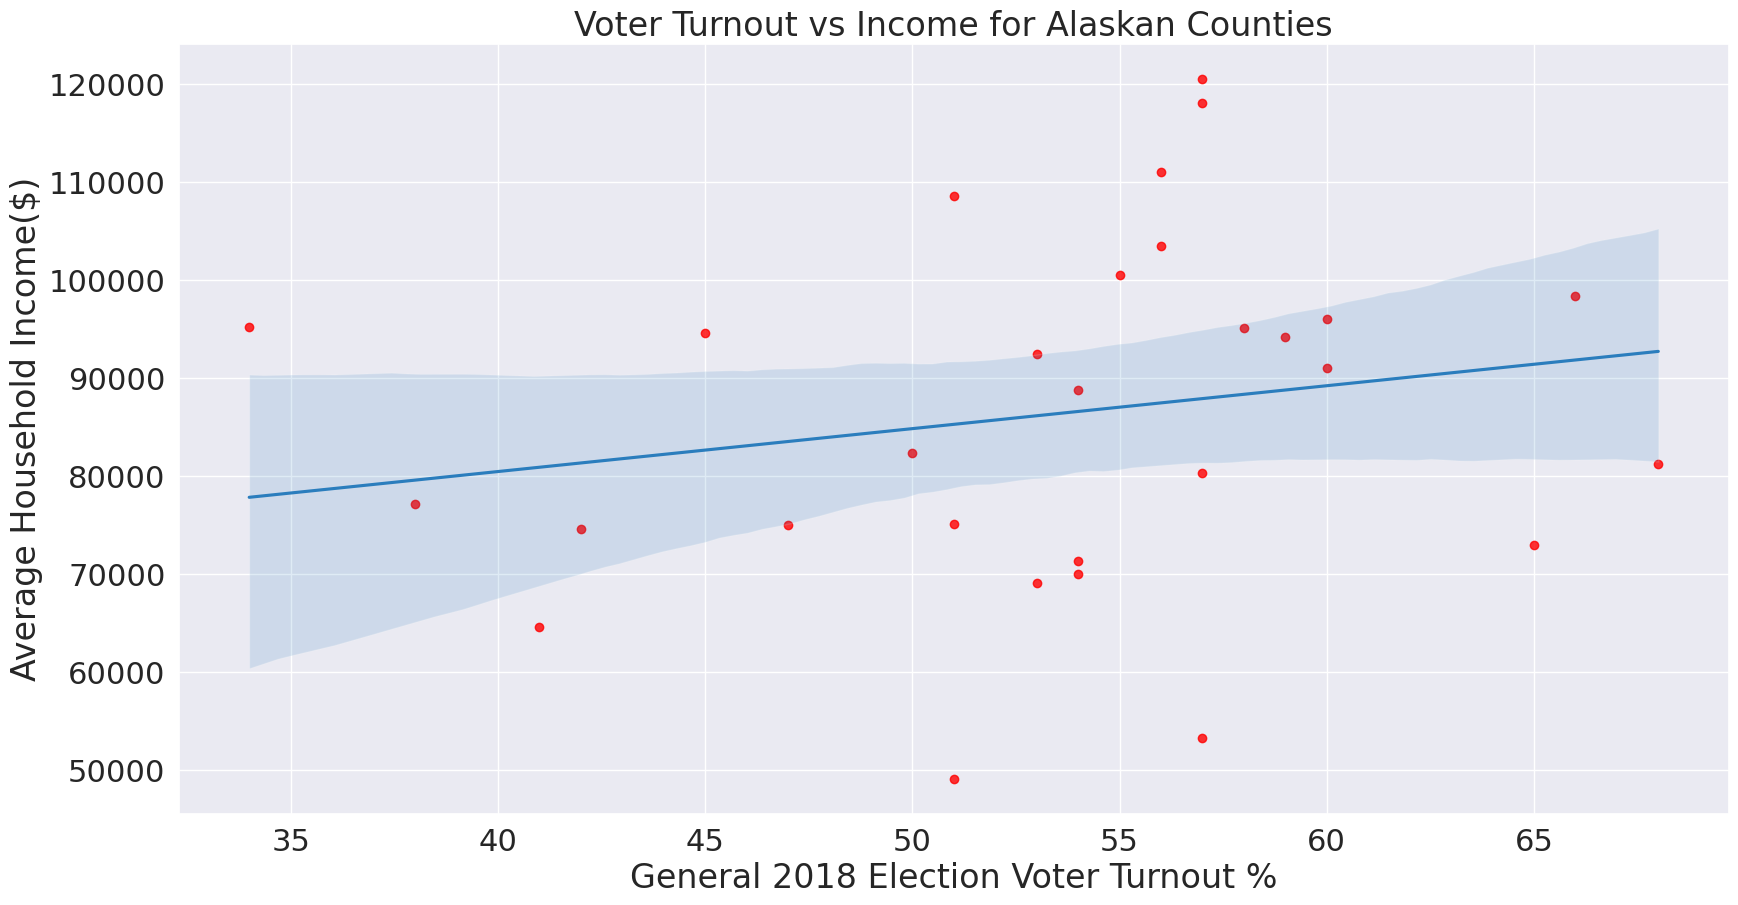

In [127]:
# FIGURE 4.6

# Income by Voter Turnout

df_AK = df_AK.withColumn("G18_TurnoutAll",
   fn.regexp_replace(fn.col("ElectionReturns_G18CountyTurnoutAllRegisteredVoters"), "[%]", "").cast('int'))
df_AK_turnout_county_income = df_AK.groupBy("County", "G18_TurnoutAll").agg({"HHIncome":"avg"})
x = df_AK_turnout_county_income.select('G18_TurnoutAll').collect()
y = df_AK_turnout_county_income.select('avg(HHIncome)').collect()

sns.set(font_scale = 2)
ax = sns.regplot(x=x, y=y, color='#2A7DBD', scatter_kws={"color": "red"})
ax.set(xlabel='General 2018 Election Voter Turnout %',
       ylabel='Average Household Income($)',
       title='Voter Turnout vs Income for Alaskan Counties')

Text(0, 0.5, 'Density')

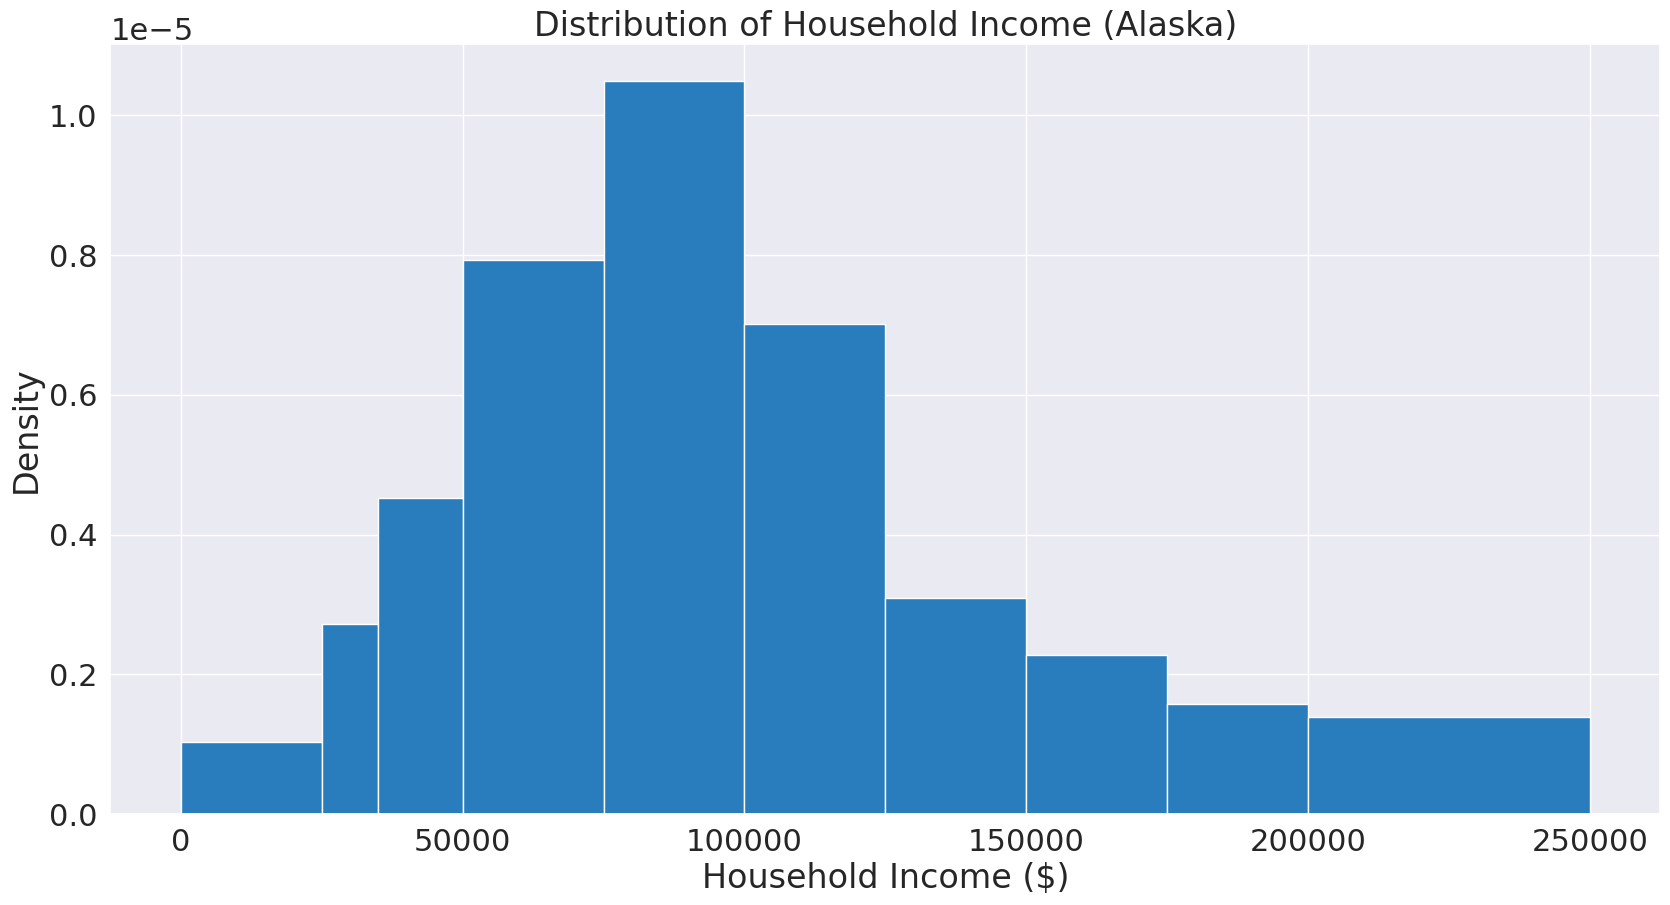

In [126]:
# FIGURE 4.7
# Histogram of Household Income
df_AK = df_AK.withColumn("HHIncome",
   fn.regexp_replace(fn.col("CommercialData_EstimatedHHIncomeAmount"), "[$]", "").cast('int'))

df_AK_HHIncome_count = sorted(df_AK.groupBy("HHIncome").count().dropna().collect())

x = [df_AK_HHIncome_count[i][0] for i in range(len(df_AK_HHIncome_count))]
y = [df_AK_HHIncome_count[i][1] for i in range(len(df_AK_HHIncome_count))]


plt.rcParams["figure.figsize"] = [20, 10]
plt.rcParams.update({'font.size': 30})
binned_income = ([0., 24999., 34999., 49999., 74999., 99999., 124999., 149999., 174999., 199999., 250000.])
plt.hist(x, bins = binned_income, density = True, color='#2A7DBD')
plt.title('Distribution of Household Income (Alaska)')
plt.xlabel('Household Income ($)')
plt.ylabel('Density')

### Models

#### Lasso Regression ON  'Voters_Gender', 'Voters_Age','EthnicGroups_EthnicGroup1Desc', INcome, County, 'General_2018' (4.4.4)


In [7]:
# cleaning and preprocessing 
df_selected = df_AK.select('Voters_Gender', 
                             'Voters_Age',
                             'EthnicGroups_EthnicGroup1Desc',
                             'General_2018','County','CommercialData_EstimatedHHIncomeAmount')

df_final = df_selected.na.fill(value='N',subset=["General_2018"])
df_final = df_final.na.fill(0)
df_final = df_final.withColumn("Income",
   fn.regexp_replace(fn.col("CommercialData_EstimatedHHIncomeAmount"), "[$]", "").cast('int'))
df_final = df_final.drop('CommercialData_EstimatedHHIncomeAmount')
df_final = df_final.dropna()

In [8]:
# preparing features
rForm = RFormula(formula="General_2018 ~ .")

fittedRF = rForm.fit(df_final)
preparedDF = fittedRF.transform(df_final) 

train, test = preparedDF.randomSplit([0.7, 0.3], seed = 447)

In [10]:
# model fitting
lr = LogisticRegression(regParam=0.0, elasticNetParam=0.0)
enModel = lr.fit(train)

23/03/23 02:55:44 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/23 02:55:44 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Train AUC: 0.7522836902497508


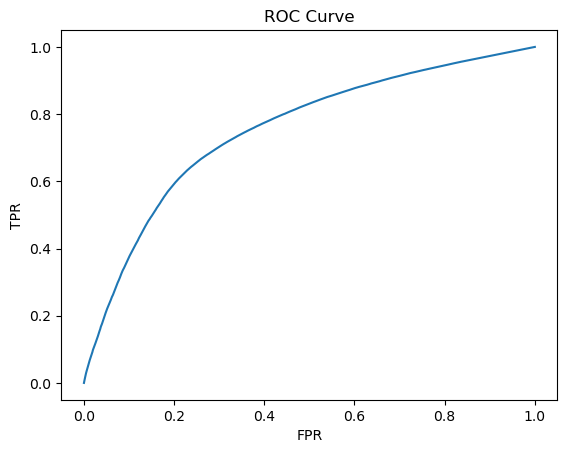

In [11]:
# Figure 4.13

# training set performance  
summary = enModel.summary
roc = summary.roc.toPandas()
roc.plot(x='FPR', y='TPR', style='-', legend=False)
plt.title('ROC Curve')
plt.ylabel('TPR')

print('Train AUC:', summary.areaUnderROC)

In [17]:
# testing set performance
fittedTest = enModel.transform(test)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
aucEvaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
test_auc = aucEvaluator.evaluate(fittedTest) 
test_auc

0.7537586832704883

In [13]:
# feature importance 
featureCols = pd.DataFrame(preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  preparedDF.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')

coefsArray = np.array(enModel.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
#coefsDF.sort_values('coefs', inplace=True)  # Sort them

coefsDF.sort_values('coefs', inplace=True,key=pd.Series.abs)

In [16]:
# Figure 4.14

# Top County features 
coefsDF[coefsDF.name.str.contains('County')].tail(10)

,coefs,name
29,0.369955,County_ALEUTIANS WEST
26,0.372337,County_WRANGELL
21,0.380401,County_NORTH SLOPE
17,0.393563,County_PRINCE OF WALES HYDER
22,0.406198,County_NORTHWEST ARCTIC
11,0.406457,County_KETCHIKAN GATEWAY
7,0.411757,County_MATANUSKA SUSITNA
12,0.424746,County_KODIAK ISLAND
25,-0.429618,County_HAINES
8,0.465906,County_FAIRBANKS NORTH STAR


In [15]:
# Figure 4.15

# features not containig county information
coefsDF[~coefsDF.name.str.contains('County')]

,coefs,name
34,-0.000004,Income
4,0.019620,EthnicGroups_EthnicGroup1Desc_Other
1,-0.031512,Voters_Age
3,0.100564,EthnicGroups_EthnicGroup1Desc_Hispanic and Por...
0,0.189138,Voters_Gender_M
5,0.321383,EthnicGroups_EthnicGroup1Desc_East and South A...
2,-0.364184,EthnicGroups_EthnicGroup1Desc_European


#### Logistic Regression with just all commercial Data columns (4.4.3)


In [25]:
### DATA TRANSFORMATION


# Selecting all Commercial Data plus some Demographic columns
CommercialData = df_AK.columns[336:381] + ['General_2018']+\
                 ['CommercialData_EstimatedHHIncomeAmount'] + ['CommercialData_HomePurchasePrice'] + \
                 ['CommercialData_LandValue'] + ['CommercialData_AreaPcntHHMarriedCoupleNoChild'] + \
                 ['CommercialData_AreaPcntHHMarriedCoupleWithChild'] + ['CommercialData_AreaPcntHHSpanishSpeaking'] + \
                 ['CommercialData_AreaPcntHHWithChildren'] + ['CommercialData_EstHomeValue']

# dupe columns dont wanna use
CommercialData.remove('CommercialData_EstimatedHHIncome')
CommercialData.remove('CommercialData_EstimatedAreaMedianHHIncome')
CommercialData.remove('CommercialData_AreaMedianHousingValue')

# columns to be transformed and dropped to put on end(right side) of df
bad_cols = ['CommercialData_EstimatedHHIncomeAmount'] + ['CommercialData_HomePurchasePrice'] + \
                 ['CommercialData_LandValue'] + ['CommercialData_AreaPcntHHMarriedCoupleNoChild'] + \
                 ['CommercialData_AreaPcntHHMarriedCoupleWithChild'] + ['CommercialData_AreaPcntHHSpanishSpeaking'] + \
                 ['CommercialData_AreaPcntHHWithChildren'] + ['CommercialData_EstHomeValue']

for i in bad_cols:
    CommercialData.remove(i)


df_AK_CommercialData = df_AK.select(CommercialData)

for col in df_AK_CommercialData.dtypes[:-8]:
    colName, colType = col
    if colType == 'int':                              
        df_AK_CommercialData = df_AK_CommercialData.na.fill(value=0,subset=[colName])
    elif colType == 'string':
        df_AK_CommercialData = df_AK_CommercialData.na.fill(value='N',subset=[colName])
    
# # transform remaining 11 columns, drop $ (first group), % (second group), turn to int 
df_AK_CommercialData = df_AK_CommercialData.withColumn("CommercialData_EstimatedHHIncomeAmount",
                fn.regexp_replace(fn.col("CommercialData_EstimatedHHIncomeAmount"), "[$]", "").cast('int'))
df_AK_CommercialData = df_AK_CommercialData.withColumn("CommercialData_LandValue",
                fn.regexp_replace(fn.col("CommercialData_LandValue"), "[$]", "").cast('int'))
df_AK_CommercialData = df_AK_CommercialData.withColumn("CommercialData_HomePurchasePrice",
                fn.regexp_replace(fn.col("CommercialData_HomePurchasePrice"), "[$]", "").cast('int'))
df_AK_CommercialData = df_AK_CommercialData.withColumn("CommercialData_EstHomeValue",
                fn.regexp_replace(fn.col("CommercialData_EstHomeValue"), "[$]", "").cast('int'))

df_AK_CommercialData = df_AK_CommercialData.withColumn("CommercialData_AreaPcntHHMarriedCoupleNoChild",
                fn.regexp_replace(fn.col("CommercialData_AreaPcntHHMarriedCoupleNoChild"), "[%]", "").cast('int'))
df_AK_CommercialData = df_AK_CommercialData.withColumn("CommercialData_AreaPcntHHMarriedCoupleWithChild",
                fn.regexp_replace(fn.col("CommercialData_AreaPcntHHMarriedCoupleWithChild"), "[%]", "").cast('int'))
df_AK_CommercialData = df_AK_CommercialData.withColumn("CommercialData_AreaPcntHHSpanishSpeaking",
                fn.regexp_replace(fn.col("CommercialData_AreaPcntHHSpanishSpeaking"), "[%]", "").cast('int'))
df_AK_CommercialData = df_AK_CommercialData.withColumn("CommercialData_AreaPcntHHWithChildren",
                fn.regexp_replace(fn.col("CommercialData_AreaPcntHHWithChildren"), "[%]", "").cast('int'))



# Dropping these columns with mostly nulls gives us much more data
df_AK_CommercialData = df_AK_CommercialData.drop('CommercialData_HomePurchasePrice')
df_AK_CommercialData = df_AK_CommercialData.drop('CommercialData_LandValue')
df_AK_CommercialData = df_AK_CommercialData.drop('CommercialData_HHComposition')


df_AK_CommercialData = df_AK_CommercialData.dropna()

In [26]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula = "General_2018 ~ .")
fittedRF = supervised.fit(df_AK_CommercialData)
preparedDF = fittedRF.transform(df_AK_CommercialData)
preparedDF.show(truncate = False)
train, test = preparedDF.randomSplit([0.7, 0.3], seed=1)

+------------------------------+----------------------------------+---------------------------------------------+-------------------------------------------+--------------------------------------------+-------------------------------------+---------------------------+-------------------------------+------------------------------+-----------------------------------+-------------------------------------------+--------------------------------------+--------------------------------------+------------------------------------------+-------------------------------+--------------------+--------------------------+---------------------------------------+-----------------------+-----------------------------+--------------------------------------------+-------------------------------------------------+---------------------------------+-----------------------------------------+-------------------------------------+------------------------------------------+---------------------------+--------------

In [27]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()
lrModel = lr.fit(train)

23/03/23 01:20:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1594.8 KiB
23/03/23 01:20:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1595.9 KiB
23/03/23 01:20:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1596.2 KiB
23/03/23 01:20:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1597.3 KiB
23/03/23 01:20:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1596.2 KiB
23/03/23 01:20:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1597.3 KiB
23/03/23 01:20:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1596.2 KiB
23/03/23 01:20:23 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1597.3 KiB
23/03/23 01:20:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

In [140]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
fittedTest = lrModel.transform(test)
aucEvaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
test_auc = aucEvaluator.evaluate(fittedTest)
test_auc

23/03/23 00:10:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1656.2 KiB


0.7328604242286646

AUC: 0.7450695912461791


Text(0, 0.5, 'TPR')

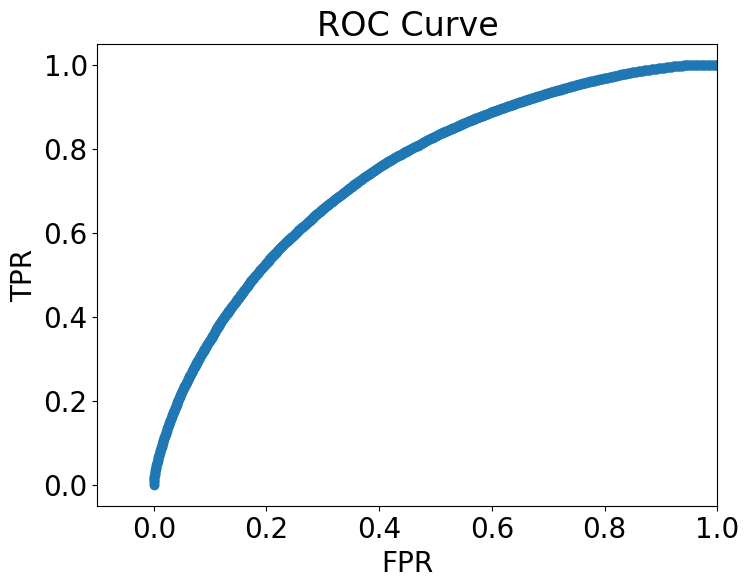

In [10]:
# Figure 4.11

summary = lrModel.summary
print("AUC:", summary.areaUnderROC)
roc = summary.roc.toPandas()
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 20})

roc.plot(x='FPR', y='TPR', xlim = [-0.1, 1], style='--o', legend=False)
plt.title('ROC Curve')
plt.ylabel('TPR')

Text(0, 0.5, 'Beta Coefficients')

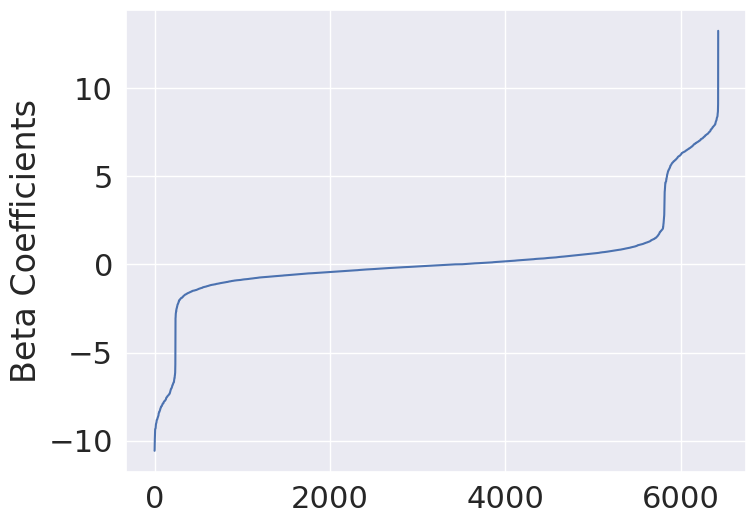

In [144]:
# Figure 4.12

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams["figure.figsize"] = (8,6)

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

#### Logistic Regression with all columns in both models (4.4.2)

In [3]:
### DATA TRANSFORMATION

# Selecting all Commercial Data plus some Demographic columns
CommercialDataPlus = df_AK.columns[336:381] + ['General_2018'] + ['County'] + ['Voters_Gender'] + ['Voters_Age'] + ['EthnicGroups_EthnicGroup1Desc']+\
                 ['CommercialData_EstimatedHHIncomeAmount'] + ['CommercialData_HomePurchasePrice'] + \
                 ['CommercialData_LandValue'] + ['CommercialData_AreaPcntHHMarriedCoupleNoChild'] + \
                 ['CommercialData_AreaPcntHHMarriedCoupleWithChild'] + ['CommercialData_AreaPcntHHSpanishSpeaking'] + \
                 ['CommercialData_AreaPcntHHWithChildren'] + ['CommercialData_EstHomeValue']

# dupe columns dont wanna use
CommercialDataPlus.remove('CommercialData_EstimatedHHIncome')
CommercialDataPlus.remove('CommercialData_EstimatedAreaMedianHHIncome')
CommercialDataPlus.remove('CommercialData_AreaMedianHousingValue')

# columns to be transformed and dropped to put on end(right side) of df
bad_cols = ['CommercialData_EstimatedHHIncomeAmount'] + ['CommercialData_HomePurchasePrice'] + \
                 ['CommercialData_LandValue'] + ['CommercialData_AreaPcntHHMarriedCoupleNoChild'] + \
                 ['CommercialData_AreaPcntHHMarriedCoupleWithChild'] + ['CommercialData_AreaPcntHHSpanishSpeaking'] + \
                 ['CommercialData_AreaPcntHHWithChildren'] + ['CommercialData_EstHomeValue']

for i in bad_cols:
    CommercialDataPlus.remove(i)


df_AK_CommercialDataPlus = df_AK.select(CommercialDataPlus)

for col in df_AK_CommercialDataPlus.dtypes[:-12]:
    colName, colType = col
    if colType == 'int':                              
        df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.na.fill(value=0,subset=[colName])
    elif colType == 'string':
        df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.na.fill(value='N',subset=[colName])
    
# # transform remaining 11 columns, drop $ (first group), % (second group), turn to int 
df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.withColumn("CommercialData_EstimatedHHIncomeAmount",
                fn.regexp_replace(fn.col("CommercialData_EstimatedHHIncomeAmount"), "[$]", "").cast('int'))
df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.withColumn("CommercialData_LandValue",
                fn.regexp_replace(fn.col("CommercialData_LandValue"), "[$]", "").cast('int'))
df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.withColumn("CommercialData_HomePurchasePrice",
                fn.regexp_replace(fn.col("CommercialData_HomePurchasePrice"), "[$]", "").cast('int'))
df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.withColumn("CommercialData_EstHomeValue",
                fn.regexp_replace(fn.col("CommercialData_EstHomeValue"), "[$]", "").cast('int'))

df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.withColumn("CommercialData_AreaPcntHHMarriedCoupleNoChild",
                fn.regexp_replace(fn.col("CommercialData_AreaPcntHHMarriedCoupleNoChild"), "[%]", "").cast('int'))
df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.withColumn("CommercialData_AreaPcntHHMarriedCoupleWithChild",
                fn.regexp_replace(fn.col("CommercialData_AreaPcntHHMarriedCoupleWithChild"), "[%]", "").cast('int'))
df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.withColumn("CommercialData_AreaPcntHHSpanishSpeaking",
                fn.regexp_replace(fn.col("CommercialData_AreaPcntHHSpanishSpeaking"), "[%]", "").cast('int'))
df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.withColumn("CommercialData_AreaPcntHHWithChildren",
                fn.regexp_replace(fn.col("CommercialData_AreaPcntHHWithChildren"), "[%]", "").cast('int'))


# Dropping these columns with mostly nulls gives us another ~140k rows of data for our model (60k with those columns, 220k without)
df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.drop('CommercialData_HomePurchasePrice')
df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.drop('CommercialData_LandValue')
df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.drop('CommercialData_HHComposition')


df_AK_CommercialDataPlus = df_AK_CommercialDataPlus.dropna()

In [4]:
from pyspark.ml.feature import RFormula

supervised = RFormula(formula = "General_2018 ~ .")
fittedRF = supervised.fit(df_AK_CommercialDataPlus)
preparedDF = fittedRF.transform(df_AK_CommercialDataPlus)
preparedDF.show(truncate = False)
train2, test2 = preparedDF.randomSplit([0.7, 0.3], seed=1)

23/03/23 00:29:46 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------------------------------+----------------------------------+---------------------------------------------+-------------------------------------------+--------------------------------------------+-------------------------------------+---------------------------+-------------------------------+------------------------------+-----------------------------------+-------------------------------------------+--------------------------------------+--------------------------------------+------------------------------------------+-------------------------------+--------------------+--------------------------+---------------------------------------+-----------------------+-----------------------------+--------------------------------------------+-------------------------------------------------+---------------------------------+-----------------------------------------+-------------------------------------+------------------------------------------+---------------------------+--------------

In [29]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression()
lrModelPlus = lr.fit(train2)

23/03/23 01:27:03 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1604.4 KiB
23/03/23 01:27:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1605.5 KiB
23/03/23 01:27:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1605.8 KiB
23/03/23 01:27:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1606.9 KiB
23/03/23 01:27:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1605.8 KiB
23/03/23 01:27:19 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1606.9 KiB
23/03/23 01:27:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1605.8 KiB
23/03/23 01:27:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1606.9 KiB
23/03/23 01:27:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
fittedTest = lrModelPlus.transform(test2)
aucEvaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')
test_auc = aucEvaluator.evaluate(fittedTest)
test_auc

23/03/23 01:41:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1665.0 KiB


KeyboardInterrupt: 

AUC: 0.7450695912461791


Text(0, 0.5, 'TPR')

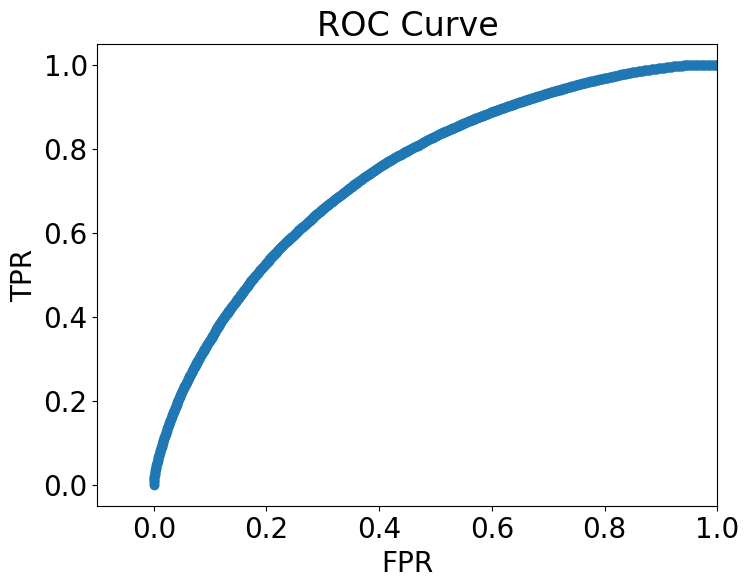

In [11]:
# Figure 4.9

summary = lrModelPlus.summary
print("AUC:", summary.areaUnderROC)
roc = summary.roc.toPandas()
plt.rcParams["figure.figsize"] = (8,6)

roc.plot(x='FPR', y='TPR', xlim = [-0.1, 1], style='--o', legend=False)
plt.title('ROC Curve')
plt.ylabel('TPR')

Text(0, 0.5, 'Beta Coefficients')

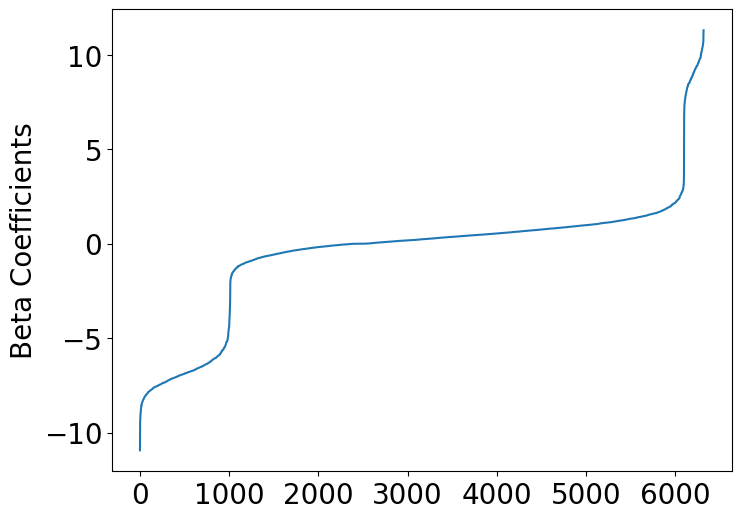

In [12]:
# Figure 4.10

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.rcParams["figure.figsize"] = (8,6)

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')

#### Decision Tree with all columns in both models (4.4.1)

In [13]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

tree_model = dt.fit(train2)

23/03/23 00:45:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1600.6 KiB
23/03/23 00:45:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1600.7 KiB
23/03/23 00:45:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1607.4 KiB
23/03/23 00:45:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1779.7 KiB
23/03/23 00:46:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1780.5 KiB
23/03/23 00:46:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1781.2 KiB
23/03/23 00:46:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1782.3 KiB
23/03/23 00:46:05 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1784.5 KiB


In [24]:
# FIGURE 4.8

from pyspark.ml.evaluation import BinaryClassificationEvaluator
# Make predictions.
predictions = tree_model.transform(test2)

# Select example rows to display.
predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
# evaluator = BinaryClassificationEvaluator(
#     labelCol="label", predictionCol="prediction", metricName="precision")
evaluator = BinaryClassificationEvaluator()
accuracy = (1 - evaluator.evaluate(predictions))
print(accuracy)

23/03/23 00:58:17 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1613.1 KiB


+----------+-----+--------------------+
|prediction|label|            features|
+----------+-----+--------------------+
|       0.0|  0.0|(6321,[2,6,10,14,...|
|       0.0|  0.0|(6321,[2,6,10,14,...|
|       0.0|  0.0|(6321,[2,6,10,14,...|
|       0.0|  1.0|(6321,[2,6,10,14,...|
|       0.0|  0.0|(6321,[2,6,10,14,...|
+----------+-----+--------------------+
only showing top 5 rows



23/03/23 00:58:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1615.4 KiB


0.6170304931660726
